# DeepFlex
*Automatically recognizing exercises and counting repititions for easy and seamless workout tracking*

**Team:** Akul Bajaj, Nhi Nguyen, Patricia Ornelas Jauregui, Akshay Pamnani, Manish Kumar Vuppugandla

**Data:** We chose to work with the “Exercise Recognition from Wearable Sensors” dataset from Microsoft Research Open Data. The data size is 3.14 GB, so we are dealing with quite large data. This dataset contains accelerometer and gyroscope recordings from over 94 participants performing various gym exercises. Here’s the link to the selected dataset: https://msropendata.com/datasets/799c1167-2c8f-44c4-929c-227bf04e2b9a.

This dataset has two files, both of which are in binary MATLAB format. For this project, we will mainly work with the exercise_data.50.0000_singleonly.mat file. This file contains "single-activity" traces, which refer to only data during exercises, already separated out by exercise (as opposed to complete exercise sessions, which include lots of time where there's no exercise happening). Our goal is to perform exercise recognition and repetition counting; therefore, working with separately labeled exercises will be easier than with the "multi-activity" sessions. There are six features at each time point (x, y, and z from both the gyroscope and accelerometer sensors) with 0.02 seconds between each time point in the series.

(insert example visualizations of the signals)

## 1. Exercise Recognition
The goal of this part of the project is to recognize which activity the user completed.


### 1.1 Data Preprocessing
We tried two different approaches to data preprocessing to extract meaningful features from our dataset.

#### 1.1a Computed Features on Sliding Time Windows
The first approach we tried was to reproduce RecoFit's preprocessing steps by creating 5 second windows of data with 4.8 seconds of overlap with the next window and then create embeddings.

Creating these sliding time windows created more training samples, which would help model performance.

1. Apply butterowrth filter to reduce noise in the signal.
2. Apply PCA on each time window x, y, and z.
3. Apply PCA on each time window to just the y and z columns.
4. Compute features from the resulting signals including autocorrelation and others.

This approach is very computationally expensive. It took too long to run this. Even for just the first 3 steps, it took over 2 minutes for each exercise set, despite using spark and other parallel processing mechanisms. Given that we had over 1.6K sets, this would take too long to complete.

In [ ]:
# For EDA
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
# For Data Pre-processing
import multiprocessing
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import PCA
from pyspark.sql.types import *
import random
import scipy.signal as signal
import scipy.io

In [ ]:
def apply_butterworth_lowpass(data):
    sampling_rate = 50 # sampling_rate of 50 Hz
    cutoff_freq = 20 # 20 Hz as specified by the paper
    filter_order = 4  # Specify the desired filter order
    nyquist_frequency = 0.5 * sampling_rate
    normalized_cutoff_frequency = cutoff_freq / nyquist_frequency
    b, a = signal.butter(filter_order, normalized_cutoff_frequency, btype='low', analog=False, output='ba')
    smoothed_data = signal.lfilter(b, a, data)
    return smoothed_data#.flatten()

def process_set(data_source, source_name, overall_set_num):
    window_duration = 5  # Window duration in seconds
    sampling_rate = 50  # Sampling rate in Hz
    window_size = int(window_duration * sampling_rate) # 250
    overlap = 10 # distinct 10 points 200ms, shared 4.8 seconds => 240 overlap

    # initialize schemas for accelerometer and gyroscope pyspark dataframes
    # accelerometer features: aYZPC and aX
    # gyroscope features: gPC
    aX_cols = [f"x{i}" for i in range(window_size)]
    aYZPC1_cols = [f"aYZPC{i}" for i in range(window_size)]
    gPC1_cols = [f"gPC{i}" for i in range(window_size)]

    common_fields = [StructField("window_index", IntegerType(), True),
        StructField("overall_set_num", IntegerType(), True),
        StructField("activity_name", StringType(), True),
        StructField("activity_set_num", IntegerType(), True)]

    yz_signal_cols = ['y','z']
    xyz_signal_cols = ['x'] + yz_signal_cols
    yzfields = [StructField(f"y", FloatType(), True),
        StructField(f"z", FloatType(), True)]

    # set the correct schema depending on the source_name
    if source_name == "accelerometer":
        pca_schema = StructType(yzfields)
        input_cols = yz_signal_cols
        output_schema = StructType(common_fields + [StructField(col, FloatType(), True) for col in aX_cols + aYZPC1_cols])
    elif source_name == "gyroscope":
        pca_schema = StructType(yzfields + \
            [StructField(f"x", FloatType(), True)])
        input_cols = xyz_signal_cols
        output_schema = StructType(common_fields + [StructField(col, FloatType(), True) for col in gPC1_cols])

    # get current set information
    set_data = data_source.filter(data_source.overall_set_num == overall_set_num)
    activity_name = set_data.select('activity_name').first()[0]
    activity_set_num = set_data.select('activity_set_num').first()[0]

    # apply butterworth lowpass filter to x, y, z columns
    x = list(set_data.select(set_data['x']).toPandas()['x'])
    y = list(set_data.select(set_data['y']).toPandas()['y'])
    z = list(set_data.select(set_data['z']).toPandas()['z'])
    smoothed_x = apply_butterworth_lowpass(x)
    smoothed_y = apply_butterworth_lowpass(y)
    smoothed_z = apply_butterworth_lowpass(z)

    # Slide the window over to compute features for each 5 second interval/window
    result_table = []
    for i in range(0, len(smoothed_x) - window_size + 1, overlap):
        # Get the windowed data that we'll use to perform PCA
        individual_window_table = {col: [] for col in input_cols} # initialize empty table
        if source_name == "gyroscope": # to compute gPC1 with all 3 dimensions (x,y,z)
            individual_window_table["x"] = smoothed_x[i:i+window_size]
        individual_window_table["y"] = smoothed_y[i:i+window_size]
        individual_window_table["z"] = smoothed_z[i:i+window_size]

        # Create dict individual_window_table to pandas DF
        individual_window_table = pd.DataFrame.from_dict(individual_window_table)
        # Convert the pandas DataFrame to a PySpark DataFrame
        pyspark_window_df = ss.createDataFrame(individual_window_table, pca_schema)

        # Combine the input columns into a single vector column
        assembler = VectorAssembler(inputCols=input_cols, outputCol='features_vect')
        assembled_df = assembler.transform(pyspark_window_df)

        # Perform PCA and keep only the first principal component
        pca = PCA(k=1, inputCol='features_vect', outputCol='pca_features')
        pca_model = pca.fit(assembled_df)
        pca_result = pca_model.transform(assembled_df).select('pca_features')

        # Flatten the pca_result DataFrame so that each element is a floatType and then transpose it
        pca_result = pca_result.rdd.map(lambda x: [float(element) for element in x.pca_features.toArray()]) \
            .flatMap(lambda x: x).collect()

        # Append the pca_row and other columns to the result_table
        if source_name == "accelerometer":
            result_table.append([i, overall_set_num, activity_name, activity_set_num] + x[i:i+window_size] + pca_result)
        elif source_name == "gyroscope":
            result_table.append([i, overall_set_num, activity_name, activity_set_num] + pca_result)

    # Write result_table to a file
    filename = f'bigfiles/{source_name}/result_table_{overall_set_num}_0625.csv'
    with open(filename, 'w') as file:
        writer = csv.writer(file)
        writer.writerows(result_table)

    return filename

def preprocess(data_source, source_name):
    # Iterate over all distinct set_nums in the data table
    # So that we can process 1 exercise set's signal in all 4 dimensions (x, y, z, t) at a time
    # Use all of the available CPU cores to preprocess all of the sets in parallel
    overall_set_nums = data_source.select('overall_set_num').distinct().rdd.flatMap(lambda x: x).collect()
    num_processes = multiprocessing.cpu_count()
    pool = multiprocessing.Pool(processes=num_processes)
    output_filenames = pool.map(process_set, overall_set_nums)
    return output_filenames

# accelerometer_features = preprocess(accelerometer_df, 'accelerometer')

#### 1.1b Aggregate Statistics
The next approach we tried was to extract features by aggregating each exercise set and computing statistics. This approach was much faster, so we ultimately used the data from this approach instead of the sliding time windows.

**Step 1:** load the data from the matlab files and add the data into a dictionary where each exercise name is a key and the corresponding value is a list of data signals corresponding to the exercise.

- Example:
dict = { "Pushups": [set1, set2]} where set1 has the format [(t0,x0,y0,z0),...,(tn,xn,yn,zn)]

- In this step, we also remove exercises that are invalid or underrepresented in the dataset.

In [ ]:
dataBaseDir = "data/exercise_recognition_from_wearable_sensors"
single_activity_file_path = os.path.join(dataBaseDir, "exercise_data.50.0000_singleonly.mat")
# Load exercise dataset
exercise_dataset = scipy.io.loadmat(single_activity_file_path, struct_as_record=False)
# Load activities and data full objects
exercise_constants = exercise_dataset['exerciseConstants'][0][0].activities
subject_data = exercise_dataset['subject_data']

# extract activities names into an array
all_activities = []
for act in exercise_constants[0]:
    all_activities.append(act[0])
    #print (act[0]) # print values for reference

# remove invalid activities from all_activities list
invalid_activities = ['Arm Band Adjustment', 'Arm straight up', '<Initial Activity>', 'Note', 'Rest', 'Invalid',
                      'Tap IMU Device', 'Unlisted Exercise', 'Device on Table', 'Tap Left Device', 'Tap Right Device',
                      'Non-Exercise', 'Triceps extension (lying down) (left arm)',
                      'Triceps extension (lying down) (right arm)', 'Alternating Dumbbell Curl']
for act in invalid_activities:
    all_activities.remove(act)

**Step 2:** For both data sources (gyroscope and accelerometer), we iterate through the dictionary keys to populate a spark dataframe for fast processing. Then, we join both dataframes with the appropriate column names. Finally, we turn this into a Pandas dataframe to easily save our table as a CSV.

In [ ]:
# Increase memory allocation
spark = SparkSession.builder.config("spark.driver.memory", "16g").config("spark.executor.memory", "16g").getOrCreate()

# turn activities_gyroscope_data_dict and activities_accelerometer_data_dict into a spark dataframe
ss = SparkSession.builder.getOrCreate()
sc = ss.sparkContext

# create schema for data
schema = StructType([
    StructField('overall_set_num', IntegerType(), True),
    StructField('activity_name', StringType(), True),
    StructField('activity_set_num', IntegerType(), True),
    StructField('time', DoubleType(), True),
    StructField('x', DoubleType(), True),
    StructField('y', DoubleType(), True),
    StructField('z', DoubleType(), True)
])

# create empty dataframes
gyroscope_df = ss.createDataFrame(sc.emptyRDD(), schema)
accelerometer_df = ss.createDataFrame(sc.emptyRDD(), schema)
gyroscope_data = []
accelerometer_data = []

# Iterate over activities and append data to dataframes
overall_set_num = 0
for activity in all_activities:
    for activity_set_num, activity_set in enumerate(activities_gyroscope_data_dict[activity]):
        for time_point in activity_set:
            data_row = (overall_set_num, str(activity), activity_set_num, float(time_point[0]), float(time_point[1]), float(time_point[2]), float(time_point[3]))
            gyroscope_data.append(data_row)
        overall_set_num += 1
    overall_set_num -= activity_set_num
    for activity_set_num, activity_set in enumerate(activities_accelerometer_data_dict[activity]):
        for time_point in activity_set:
            data_row = (overall_set_num, str(activity), activity_set_num, float(time_point[0]), float(time_point[1]), float(time_point[2]), float(time_point[3]))
            accelerometer_data.append(data_row)
        overall_set_num += 1
# Create dataframes directly from the lists of data rows
gyroscope_df = ss.createDataFrame(gyroscope_data, schema).persist()
accelerometer_df = ss.createDataFrame(accelerometer_data, schema).persist()

# Join gyroscope_df and accelerometer_df on overall_set_num, activity_set_num, activity_name, and time
df = gyroscope_df.alias('gyro').join(
    accelerometer_df.alias('acc'),
    (col('gyro.activity_set_num') == col('acc.activity_set_num')) &
    (col('gyro.activity_name') == col('acc.activity_name')) &
    (col('gyro.time') == col('acc.time')),
    'inner'
).select(
    col('gyro.activity_set_num').alias('set_num'),
    col('gyro.activity_name').alias('activity'),
    col('gyro.time'),
    col('gyro.x').alias('x_gyro'),
    col('gyro.y').alias('y_gyro'),
    col('gyro.z').alias('z_gyro'),
    col('acc.x').alias('x_acc'),
    col('acc.y').alias('y_acc'),
    col('acc.z').alias('z_acc')
).persist()

# Convert activity names to numeric labels
labelIndexer = StringIndexer(inputCol="activity", outputCol="label")
df = labelIndexer.fit(df).transform(df)

# Define the feature columns
featureCols = ["x_gyro", "y_gyro", "z_gyro", "x_acc", "y_acc", "z_acc"]

# Convert the PySpark DataFrames to Pandas DataFrames
df = df.toPandas()

**Step 3:** Since each signal has a variable amount of time points, depending on how long the subject took to complete the exercise, we decided to compute aggregate statistics as our features for each exercise set. We grouped our dataframe by the set_num and then computed the following features for each set: interquartile range, variance, skewness, kurtosis, root mean square error of the signal amplitude. We ended up with 1,631 rows (1 for each set), 36 features, and 57 exercise name labels.

- Note: we removed 3 more exercise labels in this step because they had too few samples in the dataset.

In [ ]:
# remove infrequent activities
infrequent_activities = ['Box Jump (on bench)',
 'Lawnmower (label spans both arms)',
 'Overhead Triceps Extension (label spans both arms)']
df = df[~df['activity'].isin(infrequent_activities)]

df_byset = df.groupby(["activity","set_num"])
signal_cols = [col for col in df.columns if col.startswith("x") or col.startswith("y") or col.startswith("z")]

df_means = df_byset[signal_cols].mean().add_suffix('_mean')
df_iqr = df_byset[signal_cols].quantile(0.75) - df_byset[signal_cols].quantile(0.25)
df_iqr = df_iqr.add_suffix('_iqr')
df_var = df_byset[signal_cols].var().add_suffix('_var')
df_skew = df_byset[signal_cols].skew().add_suffix('_skew')
df_kurt = df_byset[signal_cols].apply(pd.DataFrame.kurt).add_suffix('_kurt')
df_rms = df_byset[signal_cols].apply(lambda x: np.sqrt(np.mean(x**2))).add_suffix('_rms')

joined = df_means.join(df_iqr).join(df_var).join(df_skew).join(df_kurt).join(df_rms)
joined.reset_index(inplace=True)

### 1.2 Model Implementation

#### 1.2a Random Forest Model

In [ ]:
features = ['time', 'x', 'y', 'z']
label = 'activity_name'

# Select the required columns from the gyroscope_df DataFrame
data = gyroscope_df.select(features + [label])

# Apply StringIndexer to convert the label column to numeric values
labelIndexer = StringIndexer(inputCol=label, outputCol='label')
data = labelIndexer.fit(data).transform(data)

# Split the data into training and test sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Create a VectorAssembler to combine the feature columns into a single "features" column
assembler = VectorAssembler(inputCols=features, outputCol='features')
train_data = assembler.transform(train_data)
test_data = assembler.transform(test_data)

# Initialize a list to store the predictions from different classifiers
preds = []

# Define a list of classifiers to train
classifiers = [LinearSVC(maxIter=10), RandomForestClassifier(), GBTClassifier()]

# Iterate over each classifier and train a model
for classifier in classifiers:
    try:
        # Train the classifier on the training data
        model = classifier.fit(train_data)

        # Save the trained model
        model.save(f"{classifier}_v1.h5")

        # Make predictions on the test data
        predictions = model.transform(test_data)

        # Store the predictions along with the classifier name
        preds.append({str(classifier): predictions})

        # Evaluate the model's accuracy
        evaluator = MulticlassClassificationEvaluator(metricName='accuracy')
        accuracy = evaluator.evaluate(predictions)
        print("Model:", classifier, "Accuracy:", accuracy)
    except:
        # Handle any exceptions that occur during training
        print("Model:", classifier, "failed to train")

- Model: RandomForestClassifier_30c6697d91ca Accuracy: 0.7393955861485977

#### 1.2b Transformer Model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the encoder part of the UNet model
def encoder(input_shape):
    inputs = layers.Input(shape=input_shape)

    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    return models.Model(inputs=inputs, outputs=pool3)


# Define the decoder part of the UNet model
def decoder(input_shape):
    inputs = layers.Input(shape=input_shape)

    up1 = layers.UpSampling2D(size=(2, 2))(inputs)
    conv4 = layers.Conv2D(256, 3, activation='relu', padding='same')(up1)
    conv4 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv4)

    up2 = layers.UpSampling2D(size=(2, 2))(conv4)
    conv5 = layers.Conv2D(128, 3, activation='relu', padding='same')(up2)
    conv5 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv5)

    up3 = layers.UpSampling2D(size=(2, 2))(conv5)
    conv6 = layers.Conv2D(64, 3, activation='relu', padding='same')(up3)
    conv6 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv6)

    conv7 = layers.Conv2D(1, 3, activation='sigmoid', padding='same')(conv6)

    return models.Model(inputs=inputs, outputs=conv7)


# Define the UNet model
def unet(input_shape):
    encoder_model = encoder(input_shape)
    decoder_model = decoder(encoder_model.output_shape[1:])

    inputs = layers.Input(shape=input_shape)
    encoded = encoder_model(inputs)
    decoded = decoder_model(encoded)

    return models.Model(inputs=inputs, outputs=decoded)

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models

# Convert the joined_df DataFrame to a Pandas DataFrame
data = joined_df.toPandas()

# Extract features from the dataset
features = data.iloc[:, 2:].values

# Extract the activity labels
labels = data.iloc[:, 0].values

# Initialize a LabelEncoder to encode the activity labels
label_encoder = LabelEncoder()

# Encode the activity labels
encoded_labels = label_encoder.fit_transform(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42)

# Define the input shape for the UNet model
input_shape = X_train.shape[1:]

# Build the UNet model
inputs = layers.Input(shape=input_shape)
encoder_model = encoder(input_shape)(inputs)
decoder_model = decoder(encoder_model.shape[1:])(encoder_model)
outputs = layers.Conv2D(1, 1, activation='sigmoid')(decoder_model)
model = models.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


- Test Loss: 0.3791
- Test Accuracy: 0.8836

##### Predictions:

|     time     |     x      |      y      |      z      | activity_name      | label |      features       |     rawPrediction     |     probability      | prediction |
|--------------|------------|-------------|-------------|--------------------|-------|---------------------|-----------------------|----------------------|------------|
| 1595.8331711 | -60.874978 | 33.30972034 | 63.40130095 | Medicine Ball Slam |  1.0  | [1595.8332, -60.875, 33.3097, 63.4013] | [2.8961, 10.1996, 6.9043] | [0.1448, 0.51, 0.3452] |    1.0     |
| 1595.9131708 | -35.94467283 | 28.95467932 | 65.84433246 | Medicine Ball Slam |  1.0  | [1595.9132, -35.9447, 28.9547, 65.8443] | [2.9871, 10.0872, 6.9257] | [0.1494, 0.5044, 0.3463] |    1.0     |
| 1595.9531706 | -22.67046212 | 32.66120893 | 65.13473261 | Medicine Ball Slam |  1.0  | [1595.9532, -22.6705, 32.6612, 65.1347] | [2.9871, 10.0872, 6.9257] | [0.1494, 0.5044, 0.3463] |    1.0     |
| 1596.0531702 | -6.215713926 | 31.30989683 | 51.07961104 | Medicine Ball Slam |  1.0  | [1596.0532, -6.2157, 31.3099, 51.0796] | [2.9871, 10.0872, 6.9257] | [0.1494, 0.5044, 0.3463] |    1.0     |
| 1596.1731697 | 12.41570122 | 25.84273031 | 38.35109709 | Medicine Ball Slam |  1.0  | [1596.1732, 12.4157, 25.8427, 38.3511] | [2.8948, 10.0528, 7.0525] | [0.1447, 0.5026, 0.3526] |    1.0     |
| 1596.2531693 | 19.53448898 | 31.04718218 | 46.62911691 | Medicine Ball Slam |  1.0  | [1596.2532, 19.5345, 31.0472, 46.6291] | [2.9871, 10.0872, 6.9257] | [0.1494, 0.5044, 0.3463] |    1.0     |
| 1596.3731688 | 59.71162483 | 87.07217698 | 83.67798434 | Medicine Ball Slam |  1.0  | [1596.3732, 59.7116, 87.0722, 83.678] | [3.2315, 10.588, 6.1805] | [0.1616, 0.5294, 0.309] |    1.0     |
| 1596.4931683 | 67.37679857 | 186.2174589 | 164.0733122 | Medicine Ball Slam |  1.0  | [1596.4932, 67.3768, 186.2175, 164.0733] | [2.8754, 12.4374, 4.6872] | [0.1438, 0.6219, 0.2344] |    1.0     |
| 1596.6931674 | -71.50246024 | 225.4969109 | 233.5492803 | Medicine Ball Slam |  1.0  | [1596.6932, -71.5025, 225.4969, 233.5493] | [2.7517, 12.9536, 4.2947] | [0.1376, 0.6477, 0.2147] |    1.0     |
| 1596.7131674 | -43.06929657 | 174.8880218 | 191.8224046 | Medicine Ball Slam |  1.0  | [1596.7132, -43.0693, 174.888, 191.8224] | [2.7517, 12.9536, 4.2947] | [0.1376, 0.6477, 0.2147] |    1.0     |


#### 1.2c Convolutional Neural Network on images for recognition

In [ ]:
folder_path = "/home/mvuppugandla/data/duh/*.png"

image_paths = glob.glob(folder_path)

images = []
images_idx = []
for image_path in image_paths:
    images_idx.append(int(str(image_path).split("/")[-1][:-4]))
    image = cv2.imread(image_path)
    images.append(image)

images = np.array(images)
len(images)

In [ ]:
csv_path = "/home/mvuppugandla/data/rep_count_ground_truth.csv"
df = pd.read_csv(csv_path)

labels = np.array(df['exercise_name'].values)
indexes = np.array(df['set_idx'].values)

In [ ]:
temp = []
for i in range(len(images)):
    for j in range(len(indexes)):
        if indexes[j] == images_idx[i]:
            temp.append(labels[j])
            break
labels = np.array(temp)
labels = labels.reshape(-1, 1)
images.shape, labels.shape

- Exercise vs rep counts - (check for class imbalances)

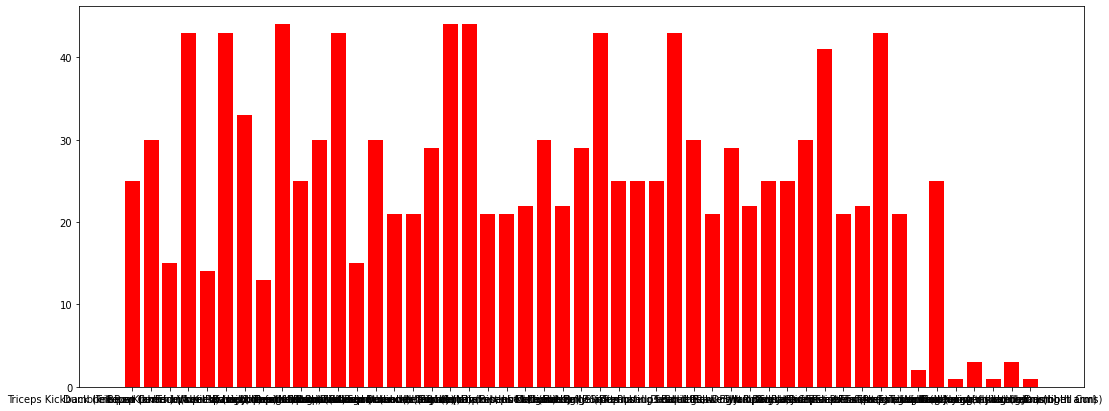

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

# Create a sequential model
model = Sequential()

# Add the first convolutional layer with 32 filters, a 3x3 kernel, and ReLU activation
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(360, 1800, 3)))

# Add max pooling layer with a 2x2 pool size
model.add(MaxPooling2D((2, 2)))

# Add the second convolutional layer with 64 filters and a 3x3 kernel
model.add(Conv2D(64, (3, 3), activation='relu'))

# Add max pooling layer with a 2x2 pool size
model.add(MaxPooling2D((2, 2)))

# Add the third convolutional layer with 128 filters and a 3x3 kernel
model.add(Conv2D(128, (3, 3), activation='relu'))

# Add max pooling layer with a 2x2 pool size
model.add(MaxPooling2D((2, 2)))

# Flatten the output from the previous layer
model.add(Flatten())

# Add a dense layer with 128 units and ReLU activation
model.add(Dense(128, activation='relu'))

# Add the output layer with 49 units (assuming it represents 49 classes) and softmax activation
model.add(Dense(49, activation='softmax'))

# Compile the model with Adam optimizer, categorical cross-entropy loss, and accuracy metric
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model on the training data for 10 epochs with a batch size of 32
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on the testing data
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

- Test Loss: 6.2747883796691895
- Test Accuracy: 0.10121457278728485


**Model Summary**

| Layer (type)                 | Output Shape           | Param #       |
|------------------------------|------------------------|--------------|
| conv2d_20 (Conv2D)           | (None, 358, 1798, 32)  | 896          |
| max_pooling2d_20 (MaxPooling)| (None, 179, 899, 32)   | 0            |
| conv2d_21 (Conv2D)           | (None, 177, 897, 64)   | 18,496       |
| max_pooling2d_21 (MaxPooling)| (None, 88, 448, 64)    | 0            |
| flatten_10 (Flatten)         | (None, 2523136)        | 0            |
| dense_20 (Dense)             | (None, 64)             | 161,480,768  |
| dense_21 (Dense)             | (None, 1)              | 65           |
| **Total params:**            |                        | **161,500,225** |
| **Trainable params:**        |                        | **161,500,225** |
| **Non-trainable params:**    |                        | **0**         |


#### 1.2d Neural network on aggregated statistics

In [ ]:
# For Neural Network model development
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# create a function to split the data into training and test sets
# each activity should be in both the training and test sets
def split_train_test(df, test_size=0.4):
    train_set = pd.DataFrame()
    test_set = pd.DataFrame()
    for activity in df.activity.unique():
        activity_df = df[df.activity == activity]
        test_rows = int(len(activity_df) * test_size)
        # get a random sample of rows for the test set
        test_set_indices = random.sample(list(activity_df.index), test_rows)
        test_set = test_set.append(activity_df[activity_df.index.isin(test_set_indices)])
        # get the remaining rows for the training set
        train_set = train_set.append(activity_df.drop(test_set_indices))
    return train_set, test_set

In [ ]:
class NeuralNetwork(nn.Module):
        def __init__(self, input_size, hidden_size, num_classes):
            super(NeuralNetwork, self).__init__()
            self.fc1 = nn.Linear(input_size, hidden_size)
            self.fc2 = nn.Linear(hidden_size, num_classes)

        def forward(self, x):
            x = torch.relu(self.fc1(x))
            x = self.fc2(x)
            return x

def evaluate_model(joined_df):
    train_set, test_set = split_train_test(joined_df)
    pandas_df = train_set
    features = pandas_df.drop(['activity', 'set_num'], axis=1)
    target = pandas_df['activity']
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    feature_tensor = torch.from_numpy(scaled_features).float()
    label_encoder = LabelEncoder()
    encoded_target = label_encoder.fit_transform(target)
    target_tensor = torch.from_numpy(encoded_target).long()

    input_size = feature_tensor.shape[1]
    hidden_size = 64
    num_classes = target_tensor.max().item() + 1  # Number of unique classes
    model = NeuralNetwork(input_size, hidden_size, num_classes)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    # Train the Neural Network
    num_epochs = 200
    batch_size = 32
    for epoch in range(num_epochs):
        correct = 0
        total = 0
        running_loss = 0.0

        for i in range(0, feature_tensor.size(0), batch_size):
            batch_features = feature_tensor[i:i+batch_size]
            batch_target = target_tensor[i:i+batch_size]

            # Forward pass
            outputs = model(batch_features)
            loss = criterion(outputs, batch_target)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += batch_target.size(0)
            correct += (predicted == batch_target).sum().item()

            # Track running loss
            running_loss += loss.item()

        # Calculate accuracy and average loss for the epoch
        accuracy = correct / total
        average_loss = running_loss / (feature_tensor.size(0) / batch_size)

        if epoch % 50 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Accuracy: {accuracy:.4f}, Loss: {average_loss:.4f}")

    # Evaluate the Neural Network on the test set
    pandas_df = test_set
    features = test_set.drop(['activity', 'set_num'], axis=1)
    target = pandas_df['activity']

    # Scale the features using the same StandardScaler from the training data to prevent data leakage
    scaled_features = scaler.transform(features)
    feature_tensor = torch.from_numpy(scaled_features).float()
    encoded_target = label_encoder.transform(target)
    target_tensor = torch.from_numpy(encoded_target).long()

    # Predict test_set using the trained NN
    test_outputs = model(feature_tensor)
    test_loss = criterion(test_outputs, target_tensor)
    test_loss_value = test_loss.item()

    _, predicted_labels = torch.max(test_outputs, 1)
    test_accuracy = (predicted_labels == target_tensor).sum().item() / len(target_tensor)

    print(f"Test Accuracy: {test_accuracy:.4f} Test Cross-Entropy Loss: {test_loss_value:.4f}")

    return model, accuracy, average_loss, test_accuracy, test_loss_value

In [ ]:
# 3-fold cross validation
k = 3
test_loss_values = []
test_accuracies = []
for i in range(3):
    model, train_accuracy, train_average_loss, test_accuracy, test_loss_value = evaluate_model(joined_df)
    print(f"=== Accuracy: {train_accuracy:.4f}, " +
          f"Loss: {train_average_loss:.4f}, Test Accuracy: " +
          f"{test_accuracy:.4f}, Test Loss: {test_loss_value:.4f}")
    test_loss_values.append(test_loss_value)
    test_accuracies.append(test_accuracy)

print(f"Cross-validated test loss: {np.mean(test_loss_values):.4f}, " +
      f"Cross-validated test accuracy: {np.mean(test_accuracies):.4f}")

### 1.3 Methods
In this project, we aim to leverage sensor data and deep learning techniques to classify exercises and predict rep counts. The following methodologies are employed:

- Data Loading and Preprocessing: We load the exercise data from a CSV file using the pandas library. The dataset contains sensor readings from accelerometers and gyroscopes worn by individuals during exercise. We perform basic data cleaning and exploration using pandas' DataFrame methods.

- Feature Engineering: We extract meaningful features from the sensor data to capture relevant patterns and information. The code selects columns starting with "x", "y", or "z" as they represent the sensor signals. We calculate statistical features such as mean, interquartile range (IQR), variance, skewness, kurtosis, and root mean square (RMS) for each activity and set combination using pandas' groupby and statistical functions.

- Data Splitting: We define a function called split_train_test to split the joined dataset into training and test sets. The function ensures that each activity is present in both sets to maintain balance and fairness during evaluation.

- Neural Network Model: We define a neural network model using PyTorch's nn.Module class. The model consists of two fully connected layers (nn.Linear) with ReLU activation between them.

- Training the Model: We train the neural network model using the training set. The features are scaled using StandardScaler, and the target labels are encoded using LabelEncoder. We use cross-entropy loss as the loss function and stochastic gradient descent (SGD) as the optimizer. The model is trained for a specified number of epochs, with batch-wise updates.

- Evaluation: After training, we evaluate the trained model's performance on the test set. We compute the accuracy and cross-entropy loss on the test set using the trained model. The accuracy metric measures the percentage of correctly classified instances, and the loss metric quantifies the dissimilarity between predicted and true labels.

- Cross-Validation: We perform k-fold cross-validation to assess the model's performance robustness. The code implements a loop to repeat the training and evaluation process multiple times, using different splits of the data. The average test accuracy and loss values are computed across the folds.

### 1.4 Experiments and Results
Present the experiments conducted during your project and report the obtained results. Include relevant performance metrics, accuracy scores, loss curves, or any other measurements used to evaluate your model's performance. Use tables, graphs, or visualizations to effectively communicate your experimental findings.
- When we used the exercise names as is, we got cross-validated test cross entropy loss: 0.9979 and cross-validated test accuracy: 0.7598
- We also tried grouping the exercise names into classes. For example:
"Dumbbell Row" maps to
        "Dumbbell Deadlift Row",
        "Dumbbell Row (knee on bench) (label spans both arms)",
        "Dumbbell Row (knee on bench) (left arm)",
        "Dumbbell Row (knee on bench) (right arm)"
With these 30 classes as the target variable instead of the 57 exercise names, we got cross-validated test loss: 0.5524, and cross-validated test accuracy: 0.8660.

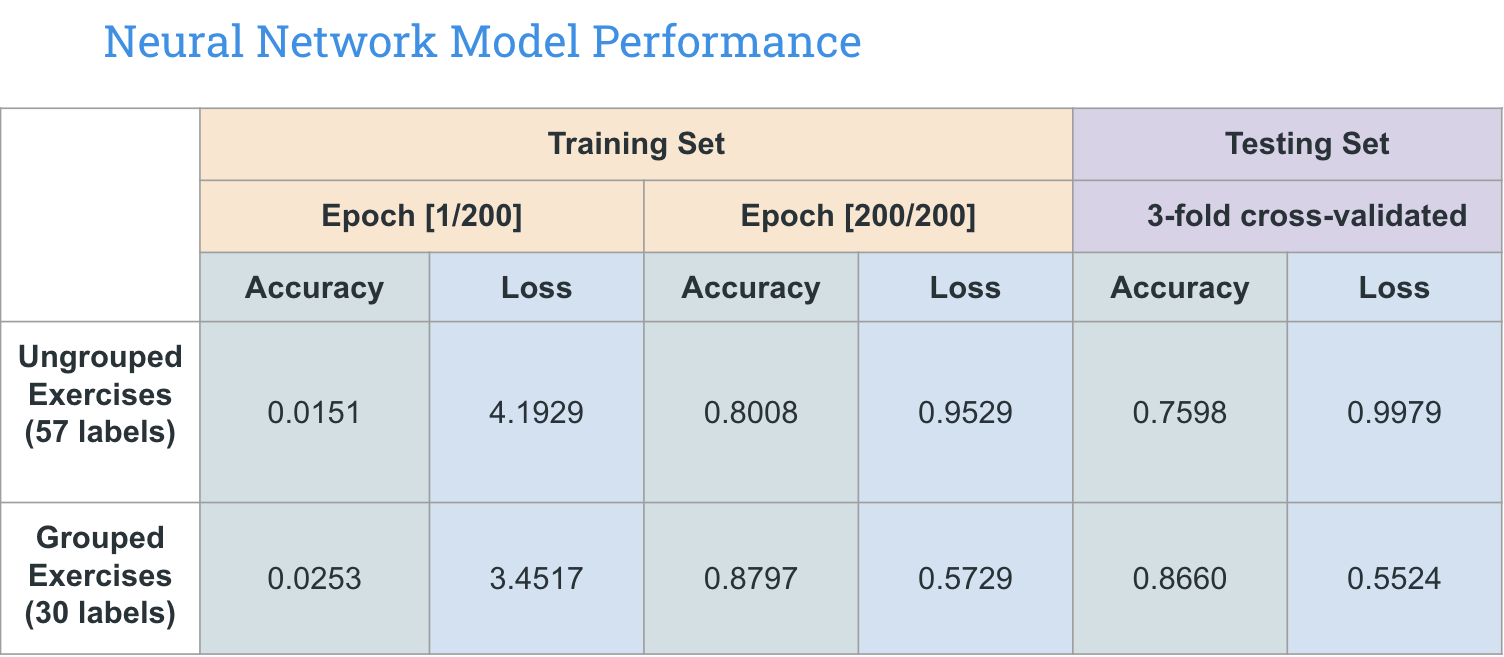

## 2. Counting Repititions
Given the signal data, the goal of this part of the project is to count how many times the user repeated the exercise.



### 2.1 Data Preprocessing
Describe the methods and steps employed to preprocess and prepare the data for your deep learning model. This may involve tasks such as data cleaning, feature engineering, data augmentation, or any other relevant preprocessing techniques.



We first extract the relevant sets, sets which have reps associated with them .
This is done by filtering the negative reps out.
These are exercises like walking etc which are not reps based.
Steps followed after that are:

1.We first extract the accelerometer signal along with the reps corresponding to the set

2.We use an elliptical band bandpass filter to filter the signal

3.We then use PCA to convert the 3 axis data to 1-d signal


These sets were exercises which do not involve reps. Exercises like walking, and other cardio based exercises.

For the relevant sets, created an Exercise Set class, having the following important attributes

1.set_idx - Index of the set obtained from the data

2.exercise_name- name of the exercise, for example - Bicep Curls

3.Reps- number of reps in that exercise(ground truth)

4.acc_signal- The accelerometer signal for that set

5.t- time points for that set

6.principle_component-The principle component of the accelerometer frame

7.Seasonality - The seasonality for the processed signal

8.Reps_pred - The reps predicted by our model

There were some more attributes also, but the more important ones have been mentioned above

In [ ]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import random
import scipy.signal as signal
import pandas as pd
from sklearn.decomposition import PCA
import math
import warnings
warnings.filterwarnings('ignore')
import scipy.signal as signal
import os


import numpy as np
from scipy import signal

import numpy as np
from scipy.signal import iirdesign, sosfilt


In [ ]:
# Load exercise dataset
exercise_dataset = scipy.io.loadmat('exercise_data.50.0000_singleonly.mat', struct_as_record=False)

# Load activities and data full objects
exercise_constants = exercise_dataset['exerciseConstants'][0][0].activities
subject_data = exercise_dataset['subject_data']

# extract activities names into an array
all_activities = []
for act in exercise_constants[0]:
    all_activities.append(act[0])
    #print (act[0]) # print values for reference


In [ ]:
activities_to_process = all_activities


In [ ]:
# define dictionaries for accelerometer and gyroscope data

rep_counts_actual = []
set_reps= {}
set_idx = 0
acc_signal = {}
gyr_signal = {}
# iterate over subject data to search for those activities and save the data related
for data_item in subject_data:
    for x in data_item:
        #print(x)

        if len(x) > 0:
            if x[0] is not None and len(x[0]) > 0:
                #print(x[0,0])
                data_activity_name = x[0,0].activityName[0]
                data_activity_reps = x[0,0].activityReps[0]
                data_item_accelDataMatrix = x[0,0].data[0,0].accelDataMatrix
                data_item_gyroDataMatrix = x[0,0].data[0,0].gyroDataMatrix
                if data_activity_name in activities_to_process:
                    #activities_accelerometer_data_dict[data_activity_name].append(data_item_accelDataMatrix)
                    #activities_gyroscope_data_dict[data_activity_name].append(data_item_gyroDataMatrix)
                    #rep_counts_actual.append(data_activity_reps)
                    set_reps[set_idx] =(data_activity_name, data_activity_reps[0])
                    acc_signal[set_idx] = data_item_accelDataMatrix
                    gyr_signal[set_idx] = data_item_gyroDataMatrix

                set_idx += 1


In [ ]:
def signal_visualization(signal):

    t, x, y, z = [], [], [], []

    for time_point in signal:

        t.append(time_point[0])
        x.append(time_point[1])
        y.append(time_point[2])
        z.append(time_point[3])


    fig, ax = plt.subplots()
    ax.plot(t, x, label = 'X')
    ax.plot(t, y, label = 'Y')
    ax.plot(t, z, label = 'Z')

    ax.set(xlabel='Time (seconds)', ylabel='Acceleration output (g)', title='')
    ax.grid()

    fig.tight_layout()
    fig.set_size_inches(25, 5)

    #plt.legend()
    #plt.show()

    #file_path = os.path.join('plots', 'sample_plot.png')
    #plt.savefig(file_path)

    return plt



def signal_decomposer(signal):

    t, x, y, z = [], [], [], []

    for time_point in signal:

        t.append(time_point[0])
        x.append(time_point[1])
        y.append(time_point[2])
        z.append(time_point[3])


    return t,x,y,z

def signal_component_visualizer(t,component):

    fig, ax = plt.subplots()
    ax.plot(t, component, label = 'X')
    #ax.plot(t, y, label = 'Y')
    #ax.plot(t, z, label = 'Z')

    ax.set(xlabel='Time (seconds)', ylabel='Acceleration output (g)', title='')
    ax.grid()

    fig.tight_layout()
    fig.set_size_inches(25, 5)

    #plt.legend()
    #plt.show()

    return fig,ax



In [ ]:
def apply_elliptical_bandpass_filter(signal):

    # Define filter specifications
    low_cutoff = 0.15  # Lower cutoff frequency in Hz
    high_cutoff = 11.0  # Upper cutoff frequency in Hz
    stop_low = 0.1  # Lower stopband frequency in Hz
    stop_high = 12.0  # Upper stopband frequency in Hz
    filter_order = 4  # Filter order

    t,x,y,z = signal_decomposer(signal)

    # Convert time points to equally spaced samples
    time_step = t[1] - t[0]  # Assuming time array is equally spaced
    sampling_freq = 1.0 / time_step

    # Perform elliptical bandpass filtering
    sos = iirdesign(wp=[low_cutoff, high_cutoff], ws=[stop_low, stop_high], gpass=1, gstop=60, fs=sampling_freq, output='sos')
    filtered_signal_x = sosfilt(sos, x)
    filtered_signal_y = sosfilt(sos, y)
    filtered_signal_z = sosfilt(sos, z)


    return filtered_signal_x,filtered_signal_y,filtered_signal_z

def signal_combiner(t,signal_x, signal_y,signal_z):

    x = signal_x
    y = signal_y
    z = signal_z

    return [np.array([t[i],x[i],y[i],z[i]]) for i in range(len(t))]

def signal_dataframe_creator(signal):

    frame = pd.DataFrame(signal)
    frame.rename(columns= {0:'t',1:'x',2:'y',3:'z'},inplace=True)

    return frame

def pc1(filtered_frame):

    t = filtered_frame[['t']]
    new_frame = filtered_frame[['x','y','z']]
    new_frame = new_frame - new_frame.mean()
    pca = PCA(n_components=1)
    pca_result = pca.fit_transform(new_frame)
    pca_frame = pd.DataFrame(pca_result)
    concatenated = pd.concat([t,pca_frame], axis=1)
    concatenated.rename(columns = {0:'pc_values'},inplace=True)


    return concatenated


In [ ]:
relevant_sets_idx = []

for idx in set_reps:
    if set_reps[idx][1] > 0:
        relevant_sets_idx.append(idx)

In [ ]:
sample_signal = acc_signal[5]


In [ ]:
plot  =  signal_visualization(sample_signal)

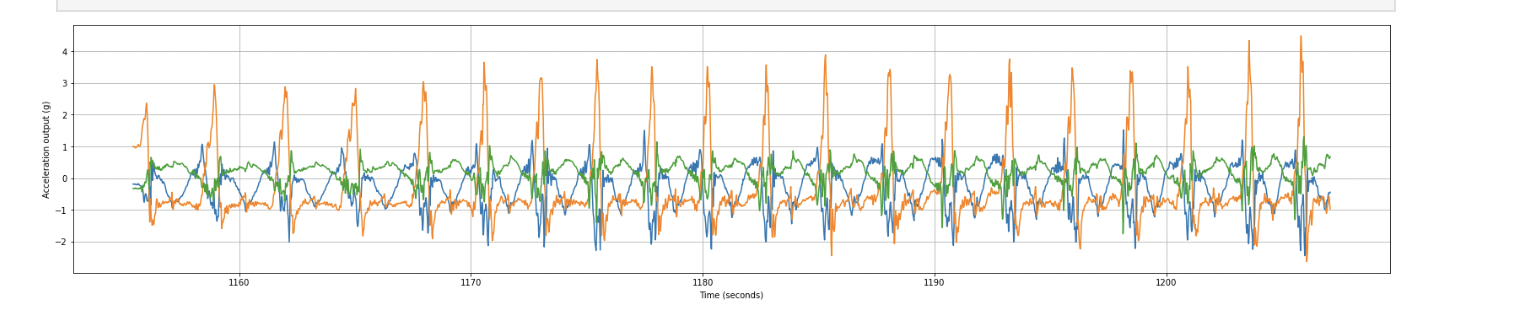

In [ ]:
set_reps[5]


('Butterfly Sit-up', 20)

In [ ]:
import numpy as np
import statsmodels.api as sm

class ExerciseSet:
    def __init__(self,set_idx,exercise_name,reps,acc_signal,gyr_signal):
        self.set_idx = set_idx
        self.exercise_name = exercise_name
        self.reps = reps
        self.acc_signal = acc_signal
        self.gyr_signal = gyr_signal
        self.t = self.acc_signal[:,0]
        self.principle_component = self.principle_component_maker()
        self.num_time_points = len(self.t)
        self.set_time = self.num_time_points * 0.02
        self.seasonality = self.seasonality_finder(self.principle_component['pc_values'])
        self.reps_pred = self.reps_predictor()

    def principle_component_maker(self):
        t,x,y,z = signal_decomposer(self.acc_signal)
        fil_x,fil_y,fil_z = apply_elliptical_bandpass_filter(self.acc_signal)
        filtered_frame = signal_dataframe_creator(signal_combiner(t,fil_x,fil_y,fil_z))
        pc_frame = pc1(filtered_frame)

        return pc_frame

    def seasonality_finder(self,data,min_threshold=40):

        acf_values = sm.tsa.acf(data, nlags=len(data)-1, fft=True)

        max_index = acf_values[min_threshold:].argmax()

        return min_threshold,min_threshold + max_index

    def reps_predictor(self):

        return round(len(self.t)/ self.seasonality[1],0)


In [ ]:
set_dict = {}

for i in relevant_sets_idx:
    set_dict[i] = ExerciseSet(i,set_reps[i][0],set_reps[i][1],acc_signal[i],gyr_signal[i])

The set_dict has the indexes of the set as keys and the corresponding ExerciseSet objects

In [ ]:
sample_set = set_dict[3]


In [ ]:
print(sample_set.exercise_name)
print(sample_set.reps)
print(sample_set.seasonality)
print('seasonality in seconds ={}'.format(sample_set.seasonality[1]*0.02))
print(sample_set.num_time_points)
print(sample_set.set_time)
print(sample_set.reps_pred)


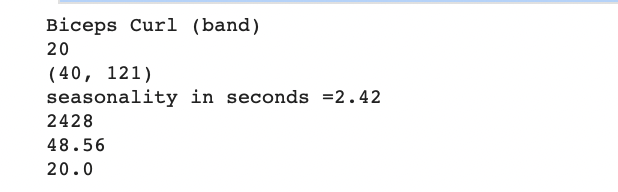

In [ ]:
fig,ax = signal_component_visualizer(sample_set.t,sample_set.principle_component['pc_values'])


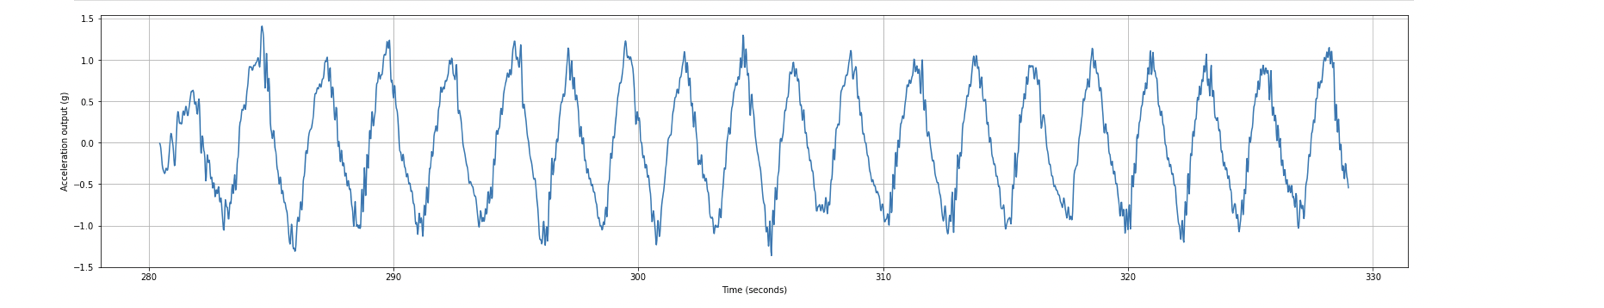

In [ ]:
def accuracy_finder(set_dict,relevant_sets_idx,threshold):

    right_preds = []

    for idx in relevant_sets_idx:
        if abs(set_dict[idx].reps - set_dict[idx].reps_pred) <= threshold:
            right_preds.append(idx)

    return len(right_preds)/len(set_dict)

def mae_calculator(set_dict,relevant_sets_idx):

    abs_diff = []

    for idx in relevant_sets_idx:
        abs_diff.append(abs(set_dict[idx].reps - set_dict[idx].reps_pred))


    return np.mean(abs_diff),np.median(abs_diff)

In [ ]:
for threshold in range(10):
    print(accuracy_finder(set_dict,relevant_sets_idx,threshold))


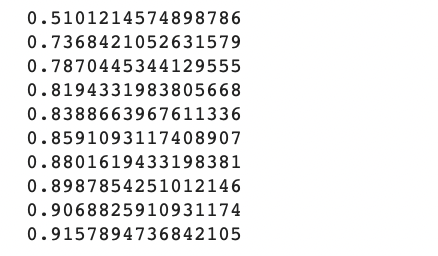

In [ ]:
mae_calculator(set_dict,relevant_sets_idx)


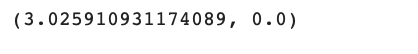

The Mean absolute error is 3.025.

### 2.2 Model Implementation
Detail the architecture and implementation details of your deep learning model. Include code snippets, well-commented code cells, or references to external code repositories if applicable. Explain the rationale behind your model choices and any modifications or enhancements you made to existing models.


1.For the baseline, model, we found the seasonality of the processed signal,using ACF.

2.The idea is that one cycle, is equal to one rep,and thus if we divide the total time of set, with the seasonality, we can get the number of reps in the set.

3.For reps_counting, we got the best performance with the baseline model.

4.The neural network and other models we used did not beat the baseline model

5.This is probably because for reps counting we do not have that much data, we only have 1235 sets, which means only 1235 rows of data

6.The model performance discussed next is for the baseline model.

The seasonality and the reps prediction are stored in the set object itself when it is created.
So the code for the model is written above itself, and is the prediction is stored in reps_pred attribute of the set.



### 2.3 Methods

During our analysis, we started with a baseline model and explored the seasonality of the processed signal using ACF (AutoCorrelation Function). The underlying concept was that each cycle corresponds to one repetition, allowing us to determine the number of repetitions in a set by dividing the total set time by the seasonality. Surprisingly, the baseline model outperformed other models, including the neural network, in terms of reps counting. It appears that the limited amount of data, with only 1235 sets or rows available, could be a contributing factor to the superior performance of the baseline model. Moving forward, we will discuss the performance of the baseline model in more detail.



### 2.4 Experiments and Results
During our evaluation, we extensively examined the performance of our model across various thresholds, which encompassed a wide range of acceptable deviation. These thresholds allowed us to assess the accuracy of predictions, from considering a single repetition deviation as incorrect, to extending the threshold to ten repetitions. To visually represent our findings, we presented an accuracy chart showcasing the corresponding accuracy rates for each threshold, progressively increasing from 1 to 10. Interestingly, we identified a systemic error that appears to originate from the inherent variations in how individuals define and execute a repetition. A notable instance of this discrepancy is evident in our observations for Russian Twists, where the model predicted 20 reps, whereas the actual count was 40. However, encouragingly, we noticed a significant improvement in accuracy when the threshold was set to 3, surpassing a remarkable 75% accuracy rate. Furthermore, we calculated the mean absolute error (MAE) to be 3.0259, indicating that, on average, our model deviated by approximately 3 repetitions. These insights provide valuable feedback for further refining and optimizing our model's performance.

In [ ]:
for threshold in range(10):
    print(accuracy_finder(set_dict,relevant_sets_idx,threshold))

## Conclusion and Future work
Deep learning was effective in recognizing exercises. Our accuracy was 87%.
The MAE for predicting reps from an exercise was 3.0259 without requiring deep learning.

Given more time, we would compute features using the sliding window approach to see if that would improve the exercise recognition performance.

For reps_counting, if we can combine peak counting of the signal along with seasonality, we can improve the predictions further.

Also, if we can get more data, models like CNN can produce much better results in counting reps

In the future, we would also like to see if we can implement online predictions so that users can get live exercise recognition and rep counts on their wearable devices.

